In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pubchempy import Compound, get_compounds
from rdkit import Chem
from brendapyrser import BRENDA
import re
import mytools

# 初始数据处理

[brendapyrser教程](https://github.com/Robaina/BRENDApyrser/blob/master/docs/examples.ipynb)

In [158]:
brenda = BRENDA('brenda.txt')

In [ ]:
brenda_ec_list = []
for rxn in brenda.reactions:
    brenda_ec_list.append( rxn.ec_number )
brenda_ec_list = list(set(brenda_ec_list))
print(len(brenda_ec_list))

In [ ]:
with open('enzyme.dat', 'r') as outfile :
    lines = outfile.readlines()

ec_list = []
for line in lines :
    if line.startswith('ID') :
        ec = line.strip().split('  ')[1]
        ec_list.append(ec.strip())
ec_list = list(set(ec_list))
print(len(ec_list))

In [165]:
def get_entry_kcat( ec ):
    r = brenda.reactions.get_by_id(ec)
    all_data = r.Kcatvalues
    result = []
    for sub in all_data.keys():
        sub_data = all_data[sub]
        for entry in sub_data:
            if ('Â°C' not in entry['meta'] ) or ( '#' not in entry['meta']) \
                        or (';' in entry['meta']) or ('specified' in entry['meta'] ):
                continue
            else:
                value = entry['value']
                temperature = html.unescape( entry['meta'].split('Â°C')[0] ) [-2:]
                try :
                    temperature = float(temperature)  
                except:
                    continue
                    
                if 'mutant' not in entry['meta']:
                    enz_type = 'WT'
                    mutation = 'None'
                else:
                    mut4 = re.findall('[A-Z][0-9][0-9][0-9][0-9][A-Z]',entry['meta'])
                    mut3 = re.findall('[A-Z][0-9][0-9][0-9][A-Z]',entry['meta'])
                    mut2 = re.findall('[A-Z][0-9][0-9][A-Z]',entry['meta'])
                    mut1 = re.findall('[A-Z][0-9][A-Z]',entry['meta'])
                    mut_list = mut4 + mut3 + mut2 + mut1
                    if len(mut_list) < 1:
                        continue
                    else:
                        enz_type = 'MUT'
                        mutation = '/'.join(mut_list) 
                    
                p_ref = entry['meta'].split('#')[1].strip()
                if ',' in p_ref:
                    p_ref_list = p_ref.split(',')
                else:
                    p_ref_list = [ p_ref ]
                p_ids = []
                for ref in p_ref_list:
                    p_ids.append( r.proteins[ref]['proteinID'] )
                    
                for p_id in p_ids:
                    if p_id == '':
                        continue
                    else:
                        result.append( {'EC':ec,'temperature':float(temperature),'sub': sub, 
                                'UniProtID':p_id,'EnzymeType':enz_type,'Mutation':mutation,'kcat': float(value) } )
    return result

In [ ]:
from tqdm import tqdm
import html

result = []
for ec in tqdm(brenda_ec_list, desc='当前处理进度：'):
    result += get_entry_kcat(ec)

In [ ]:
# 数据处理，选择kcat大于0以及删去NAN
rawdata_brenda = pd.DataFrame(result)
rawdata_brenda = rawdata_brenda[rawdata_brenda['kcat'] > 0]

# 除去UniProtID可能包含的空格
for i,id in enumerate(rawdata_brenda['UniProtID']):
    rawdata_brenda.loc[i, 'UniProtID'] = id.split(' ')[0]

# 数据进一步处理

In [2]:
# 根据module_ec.txt确定pathway

kcat_merge = pd.read_csv('kcat_merge.csv')
ec_module = pd.read_csv('module_ec.txt',sep='\t',header=None)
ec_module = ec_module.drop([0],axis=1)
ec_module = ec_module.rename(columns = {1:'EC', 2:'Pathway'})

In [3]:
enz_paths = {'Primary':set(),'Secondary':set()}
for i, path in enumerate(ec_module['Pathway']):
    ec = ec_module['EC'][i][2:]
    if 'Primary' in path:
        enz_paths['Primary'].add(ec)
    else:
        enz_paths['Secondary'].add(ec)

In [ ]:
from matplotlib_venn import venn2
venn2([enz_paths['Primary'],enz_paths['Secondary']], ['Primary','Secondary'])

# 随机过采样减小数据分布差异

In [2]:
kcat_merge = pd.read_csv('kcat_merge.csv')

In [3]:
high_set = (kcat_merge[kcat_merge['Temp']>=40]).reset_index().drop(['index'],axis=1)
low_set = (kcat_merge[kcat_merge['Temp']<=20]).reset_index().drop(['index'],axis=1)

In [16]:
import random

over_low, over_high = [],[]
for i in range(2*high_set.shape[0]):
    rand_idx = np.random.randint(high_set.shape[0], size=1)[0]
    temp_data = dict(high_set.iloc[rand_idx])
    over_high.append(temp_data)
for i in range(2*low_set.shape[0]):
    rand_idx = np.random.randint(low_set.shape[0], size=1)[0]
    temp_data = dict(low_set.iloc[rand_idx])
    over_low.append(temp_data)
over_set = over_low + over_high
random.shuffle(over_set)
over_pd = pd.DataFrame(over_set)

process_pd = (pd.concat([ kcat_merge, over_pd]) ).reset_index().drop(['index'],axis=1)
T_K_norm = mytools.scale_minmax(process_pd['Temp_K'])
inv_T_norm = mytools.scale_minmax(process_pd['Inv_Temp'])
process_pd['Temp_K_norm'] = T_K_norm
process_pd['Inv_Temp_norm'] = inv_T_norm

# 数据分布

In [17]:
process_pd = pd.read_csv('processed_data.csv')
kcat_merge = pd.read_csv('kcat_merge.csv')

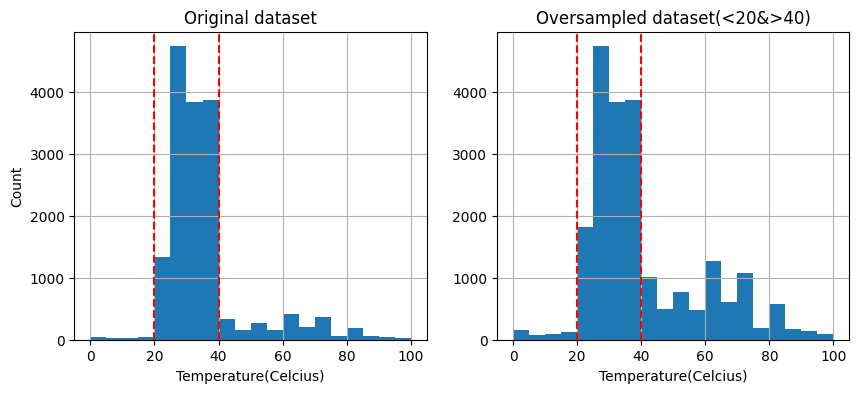

In [18]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(kcat_merge['Temp'],bins=20);
axs[1].hist(process_pd['Temp'],bins=20);
axs[0].set_title('Original dataset')
axs[0].set_ylabel('Count')
axs[1].set_title('Oversampled dataset(<20&>40)')
for ax in axs:
    ax.set_xlabel('Temperature(Celcius)')
    ax.axvline(x=20,color='r', linestyle='--')
    ax.axvline(x=40,color='r', linestyle='--')
    ax.grid()

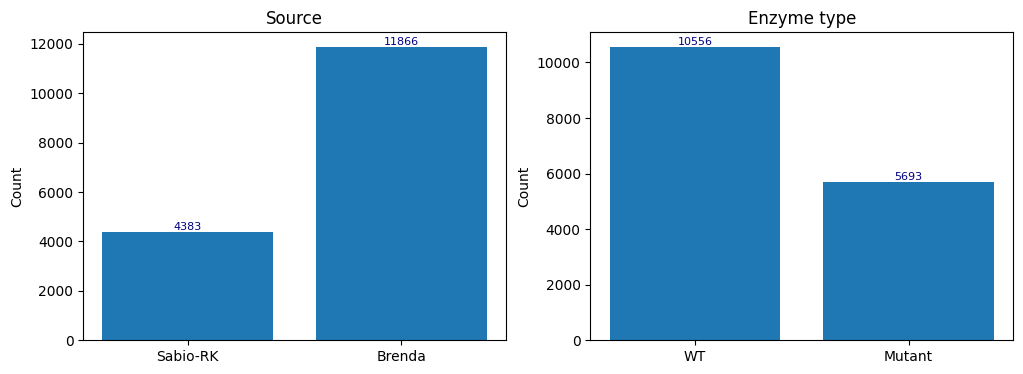

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
bars = axs[0].bar(['Sabio-RK','Brenda'],
           [list(kcat_merge['source']).count('sabiork'), list(kcat_merge['source']).count('brenda')])
axs[0].bar_label(bars, fontsize=8, color='navy')
axs[0].set_title('Source')

bars = axs[1].bar(['WT','Mutant'],
        [list(kcat_merge['EnzymeType']).count('WT'), list(kcat_merge['EnzymeType']).count('MUT')])
axs[1].bar_label(bars, fontsize=8, color='navy')
axs[1].set_title('Enzyme type')

for ax in axs:
    ax.set_ylabel('Count')

# 随机划分训练集和测试集

In [2]:
process_pd = pd.read_csv('processed_data.csv')

In [32]:
ratio = 0.1
idx = np.arange(process_pd.shape[0])
np.random.shuffle(idx)
num_split = int( process_pd.shape[0] * ratio)
idx_test, idx_train = idx[:num_split], idx[num_split:]
test_data = process_pd.iloc[idx_test].reset_index().drop(['index'],axis=1)
train_data = process_pd.iloc[idx_train].reset_index().drop(['index'],axis=1)

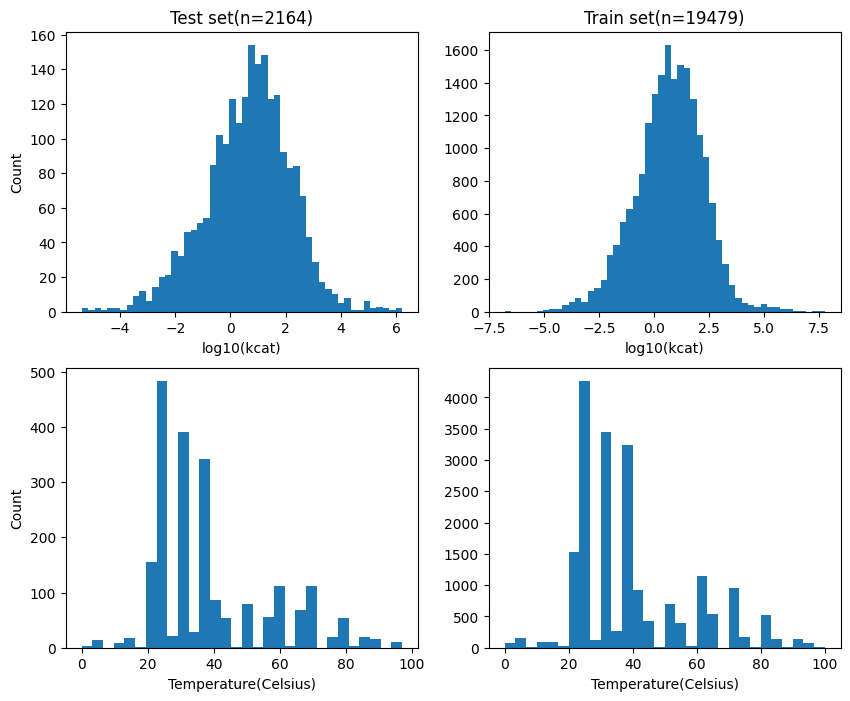

In [36]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
axs[0][0].hist(np.log10(test_data['kcat']),bins=50 );
axs[0][1].hist( np.log10(train_data['kcat']),bins=50 );
for ax in axs[0]:
    ax.set_xlabel('log10(kcat)')
axs[0][0].set_ylabel('Count')
axs[0][0].set_title('Test set(n=2164)');
axs[0][1].set_title('Train set(n=19479)');
axs[1][0].hist(test_data['Temp'],bins=30 );
axs[1][1].hist(train_data['Temp'],bins=30 );
axs[1][0].set_ylabel('Count');
for ax in axs[1]:
    ax.set_xlabel('Temperature(Celsius)')

In [3]:
data = mytools.smiles2graph(process_pd['smiles'][1])

In [4]:
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
import torch

In [10]:
datas = []

for i, smi in tqdm(enumerate(process_pd['smiles']), desc=f'总数据量为 {process_pd.shape[0]}it'):

    # Step 1: 将 SMILES 转换为图结构
    data = mytools.smiles2graph(smi)
    
    # Step 2: 添加额外的标量特征
    data.Temp_K_norm = torch.tensor(process_pd['Temp_K_norm'][i], dtype=torch.float32)
    data.Inv_Temp_norm = torch.tensor(process_pd['Inv_Temp_norm'][i], dtype=torch.float32)
    data.kcat = torch.tensor(np.log10(process_pd['kcat'][i]), dtype=torch.float32)
    
    # Step 3: 添加 SMILES
    data.smi = smi
    
    # Step 4: 添加序列信息
    data.seq = process_pd['seq'][i]
    
    datas.append(data)

总数据量为 21643it: 21643it [00:21, 1025.09it/s]


In [11]:
torch.save(datas, 'datas.pt')